# Connecting Postgres to Spark

Start with creating a new notebook, installing Spark:

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

We'll use Spark to write directly to our Postgres database. But in order to do so, there are few more lines of code we need.

First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

You should get a message containing the words "HTTP request sent, awaiting response… 200 OK," indicating that your request was processed without a problem.

Then, start a Spark session with an additional option that adds the driver to Spark:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

We have performed the first two steps of the ETL process before with PySpark, so let's quickly review those.

## Extract
We can connect to data storage, then extract that data into a DataFrame. We'll do this on two datasets, and be sure to replace the bucket name with one of your own.

We'll start by importing SparkFiles from PySpark into our notebook. This will allow Spark to add a file to our Spark project.

Next, the file is read in with the read method and combined with the csv() method, which pulls in our CSV stored in SparkFiles and infers the schema. SparkFiles.get() will have Spark retrieve the specified file, since we are dealing with a CSV.  The "," is the chosen separator, and we will have Spark determine the head for us. Enter the following code:

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://YOUR-BUCKET-NAME.s3.amazonaws.com/user_data.csv"
spark.sparkContext.addFile(url)
user_data_df = spark.read.csv(SparkFiles.get("user_data.csv"), sep=",", header=True, inferSchema=True)

Finally, an action is called to show the first 10 runs and confirm our data extraction by entering the following code:

In [ ]:
# Show DataFrame
user_data_df.show()

Repeat a similar process to load in the other data. Enter the code:

In [ ]:
url ="https://YOUR-BUCKET-NAME.s3.amazonaws.com/user_payment.csv"
spark.sparkContext.addFile(url)
user_payment_df = spark.read.csv(SparkFiles.get("user_payment.csv"), sep=",", header=True, inferSchema=True)

# Show DataFrame
user_payment_df.show()

## Transform
Now that the raw data stored in S3 is available in a PySpark DataFrame, we can perform our transformations.

First, join the two tables:

In [ ]:
# Join the two DataFrame
joined_df = user_data_df.join(user_payment_df, on='username', how='inner')
joined_df.show()

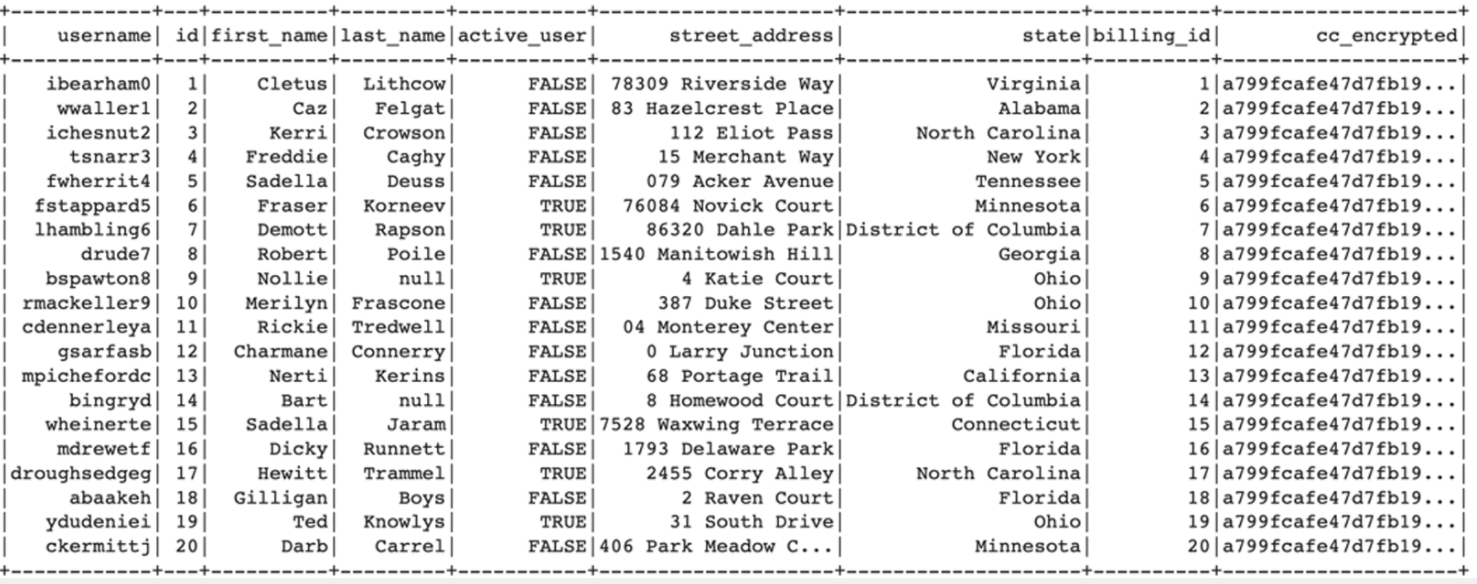

Next, drop any rows with null or "not a number" (NaN) values:

In [ ]:
# Drop null values
dropna_df = joined_df.dropna()
dropna_df.show()

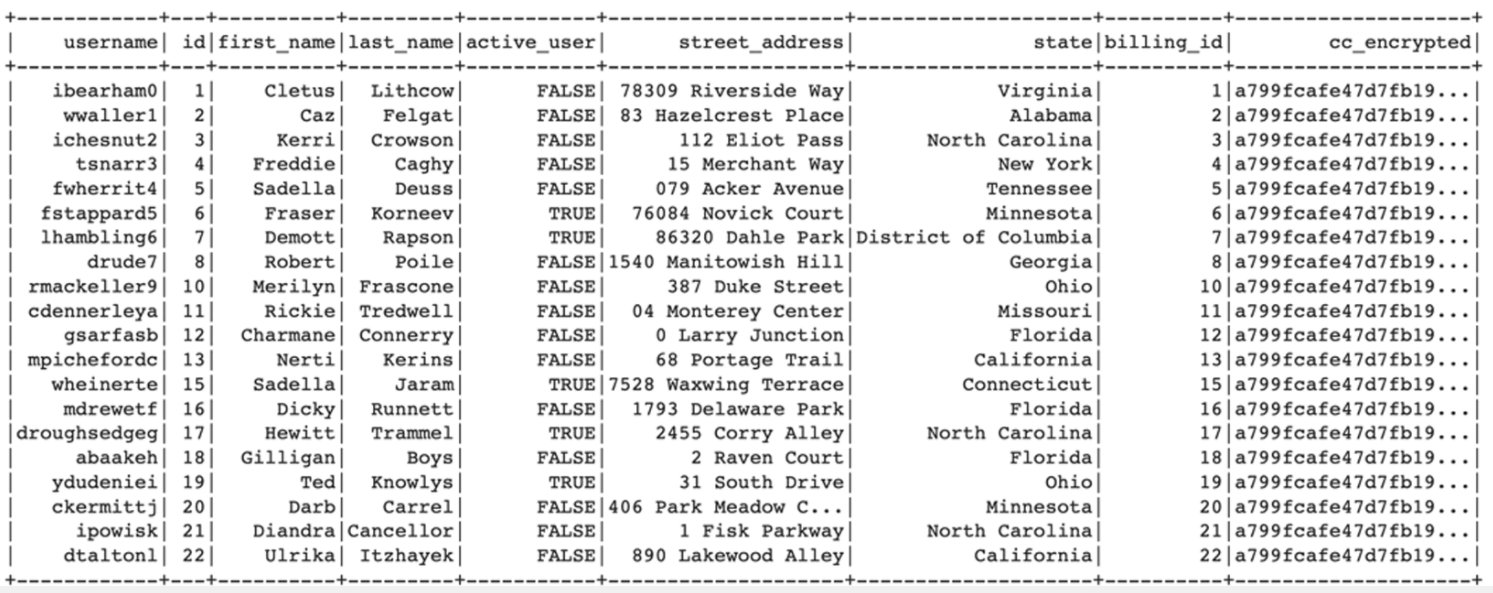

Filter for active Users

In [ ]:
# Load in sql function to use columns
from pyspark.sql.functions import col

In [ ]:
# Filter for only coumns with active users
cleaned_df = dropna_df.filter(col('active_user') == True)
cleaned_df.show()

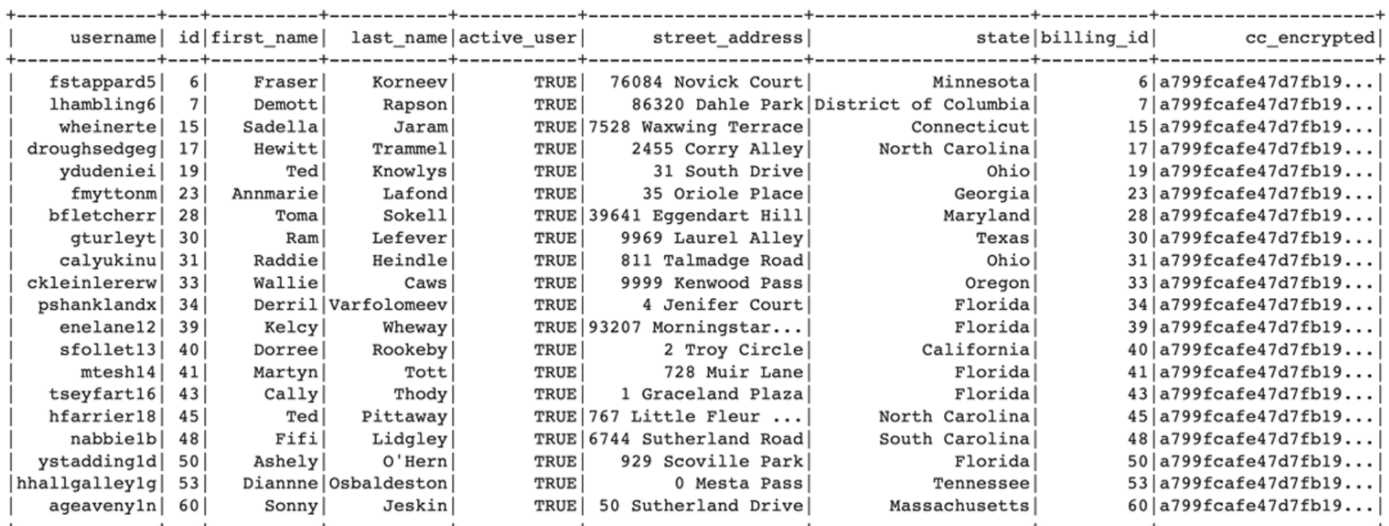

Next, select columns to create three different DataFrames that match what is in the AWS RDS database. Create a DataFrame to match the active_user table:

In [ ]:
# Create user dataframe to match active_user table
clean_user_df = cleaned_df.select([]'id', 'first_name', 'last_name', 'username'])
clean_user_df.show()

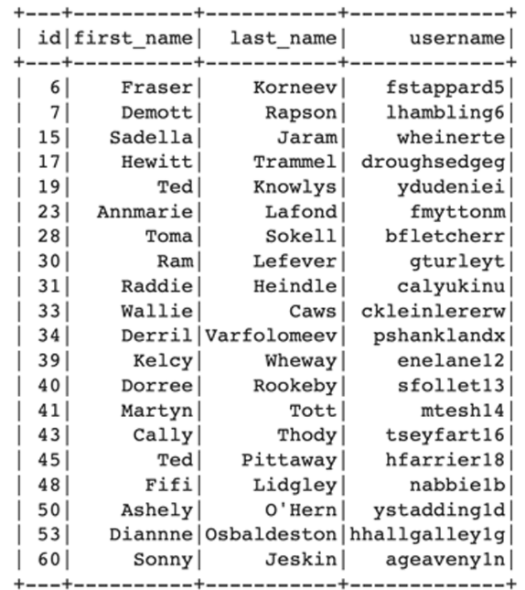

Next, create a DataFrame to match the billing_info table:

In [ ]:
# Create user dataframe to match billing_info table
clean_billing_df = cleaned_df.select(['billing_id', 'street_address', 'state', 'username'])
clean_billing_df.show()

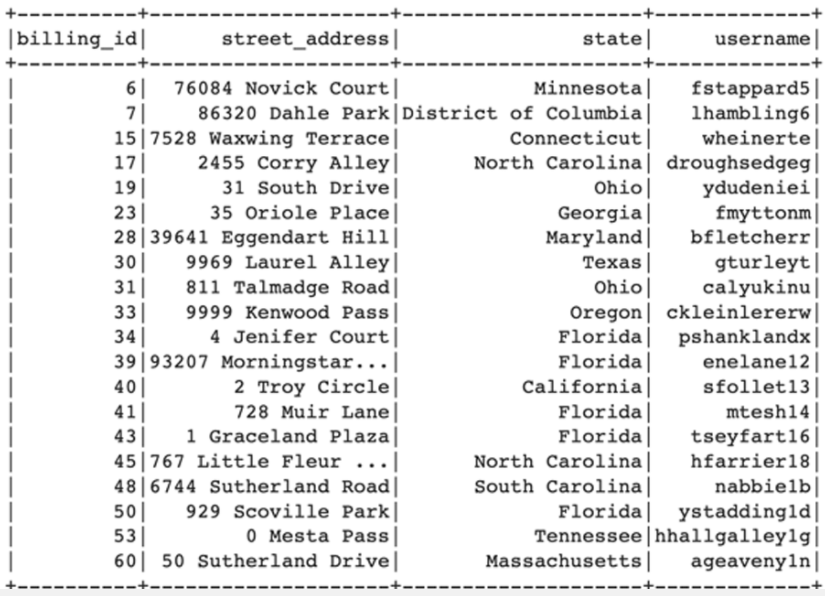

Finally, create a DataFrame to match the payment_info table:

In [ ]:
# Create user dataframe to match paymen_info table
clean_payment_df = cleaned_df.select(['billing_id', 'cc_encrypted'])
clean_payment_df.show()

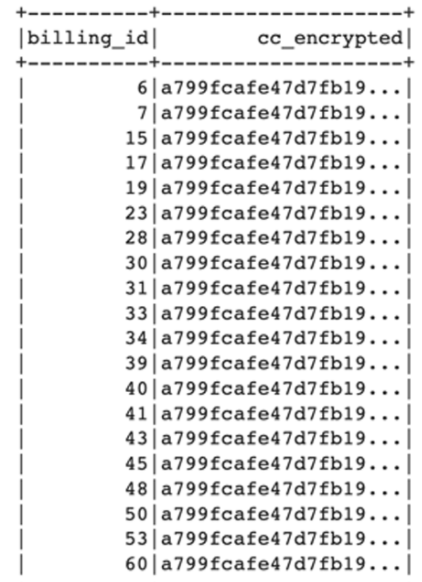

Once our data has been transformed to fit the tables in our database, we're ready to move on to the "Load" step.

## Load
The final step is to get our transformed raw data into our database. PySpark can easily connect to a database to load the DataFrames into the table. First, we'll do some configuration to allow the connection with the following code:

In [ ]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://<connection string>:5432/<database-name>"
config = {"user":"postgres",
          "password": "<password>",
          "driver":"org.postgresql.Driver"}

You'll need to provide your username and password, and also supply the AWS server name where <connection string> is located in the code above. To find it in PgAdmin, right-click AWS in the Server directory listing on the left side of PgAmin, and then select Properties in the drop-down menu. Select the Connection tab in the window that opens, and then select the address in the Host name/address field. Copy that address and paste it in place of <connection string>.

Let's further break down what's happening here:

mode is what we want to do with the DataFrame to the table, such as overwriteor append. We'll append to the current table because every time we run this ETL process, we'll want more data added to our database without removing any.
The jdbc_url is the connection string to our database.
Replace <connection string> with the endpoint connection url found from your AWS RDS console.
Replace <database name> with the name of your database you wish to connect to.
A dictionary of configuration that includes the user, password, and driverto what type of database is being used.
The user field is the username for your database, which should bepostgres if you followed with the creation of the RDS instance. Otherwise, enter the one you created.
The password would be the password you created when making the RDS instance.

### NOTE
If you forget anything like the name of the database or user name you can check on pgAdmin for these values. Be sure that you are entering the name of the database and not the name of your server in the connection string.

The cleaned DataFrames can then be written directly to our database by using the .write.jdbc method that takes in the parameters we set:

The connection string stored in jdbc_url is passed to the URL argument.
The corresponding name of the table we are writing the DataFrame to.
The mode we're using, which is "append."
The connection configuration we set up passed to the properties.
The code is as follows:

In [ ]:
# Write DataFrame to active_user table in RDS
clean_user_df.write.jdbc(url=jdbc_url, table='active_user', mode=mode, properties=config)

In [ ]:
# Write dataframe to billing_info table in RDS
clean_billing_df.write.jdbc(url=jdbc_url, table='billing_info', mode=mode, properties=config)

In [ ]:
# Write dataframe to payment_info table in RDS
clean_payment_df.write.jdbc(url=jdbc_url, table='payment_info', mode=mode, properties=config)

Let's wrap up by double-checking our work and running queries in pgAdmin on our database to confirm that the load did exactly what we wanted:

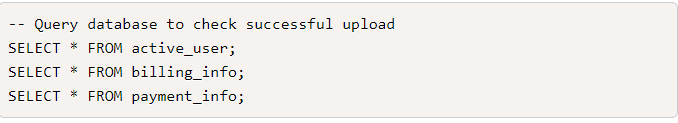